# Laboratorium 1

In [1]:
# Kompilator JIT - zastępuje Cythona
%pip install numba

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# preluda importów

# Pythonowe funkcje z biblioteki standardowej
from collections import Counter
from math import exp, pi
from random import gauss as gauss_builtin_rng, random as uniform_bulitin_rng

# Numpy
import numpy as np

# Wykresy
import matplotlib.pyplot as plt

# Gęstości teoretyczne
from scipy.stats import norm, uniform, poisson, expon, binom

# Numba nopython JIT
from numba import njit

In [3]:
plt.rcParams["figure.figsize"] = [8, 5.5]

## Zadanie 1
Wykorzystam generatory w języku Python, które tworzy się dokładnie tak samo jak zwykłe funkcje, jedynie zamieniając 'return' na 'yield'.
Pozwala to utrzymać stan generatora liczb losowych w łatwy sposób bez tworzenia całej klasy.

In [4]:
def linear_rng(last_x, m, a_0, a_1):
    last_x = (last_x * a_1 + a_0) % m
    return last_x

def linear_generator(
        seed=123,
        k = 1,
        a_0 = (exp(1) * 1e9)//1,
        a_1 = (pi * 1e9)//1, 
        m = 2 ** 35
    ):
    last_x = linear_rng(seed, m, a_0, a_1)      
    while True:
        yield last_x/(m-1)
        last_x = linear_rng(last_x, m, a_0, a_1)

def sample_rng(count, generator):
    return [next(generator) for _ in range(count)]

In [5]:
sample_rng(5, linear_generator(seed=123))

[0.3252951457201647,
 0.9004038572573453,
 0.6893234253130307,
 0.5202975273283751,
 0.2604303360061147]

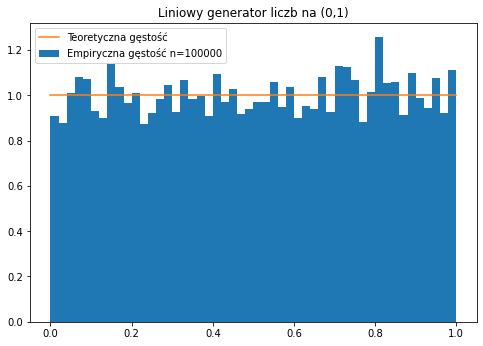

In [6]:
sample_count = 100000
plt.hist(
    sample_rng(sample_count, linear_generator(seed=123)),
    density=True,
    bins=50
)

plt.plot(
    [0, 1],
    [1, 1]
)

plt.title("Liniowy generator liczb na (0,1)")
plt.legend(["Teoretyczna gęstość", f"Empiryczna gęstość n={sample_count}"])
plt.show()

Faktycznie jest całkiem niezły.

## Zadanie 2


### Gęstości 
$f_{cosnorm}(x) = \frac{1 + \cos(2\pi x)}{1 + e^{-2\pi^2}} \frac{e^{-x^2/2}}{\sqrt{2\pi}}$

Skorzystam z modyfikacji metody eliminacji, ponieważ rozkład nie jest ograniczony na osi $x$. Potrzebne jest $a\cdot g(x)$, które pokryje gęstość. Biorąc pod uwagę, że gęstość jest "połączeniem" cosinusa i rozkładu normalnego, to być może $2 \cdot N(0, 1)$ ją pokryje.

In [7]:
def density_cosnorm(x):
    return (
        ( (1 + np.cos(2*pi*x)) * np.exp(-x*x/2) ) /
        ( (1 + np.exp(-2 * pi*pi)) * np.sqrt(2*pi) )
    )

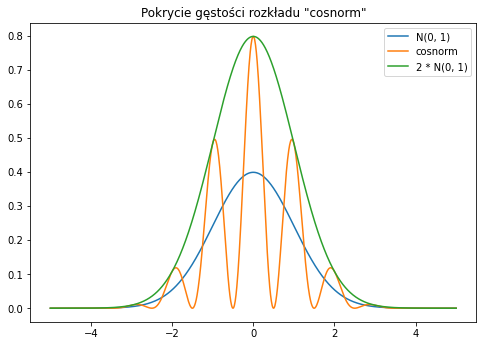

In [8]:
space = np.linspace(-5, 5, 1000)
normal = norm.pdf(space)
modified = density_cosnorm(space)
plt.plot(space, normal)
plt.plot(space, modified)
plt.plot(space, normal * 2)
plt.title("Pokrycie gęstości rozkładu \"cosnorm\"")
plt.legend([
    "N(0, 1)",
    "cosnorm",
    "2 * N(0, 1)"
])
plt.show()

### Generator Metody Eliminacji

In [9]:
def EM_rng(f_density, a):
    x = gauss_builtin_rng(0, 1)
    y = uniform_bulitin_rng()
    while y > f_density(x)/(a*norm.pdf(x)):
        x = gauss_builtin_rng(0, 1)
        y = uniform_bulitin_rng()
    return x

In [10]:
EM_rng(density_cosnorm, 2)

0.3466660610296511

Niestety jest dosyć powolny. Funkcja generująca 100 tyś. próbek zajmuje sporo czasu. Jest napisana w "czystym" Pythonie bez dużej pomocy ze strony `numpy`. Jest to dobra okazja, żeby przetestować pakiet `numba`.

### Test kompilacji Just-In-Time z `numba`
Jedyną zmianą do kodu jaką musiałem wprowadzić to zamiana `scipy.stats.norm.pdf` na własną funkcję i oczywiście dodanie dekoratora `@njit`, który jest skrótem dla `@numba.jit(nopython = True)`. W trybie `nopython` `numba` jest w stanie kompilować funkcje w trybie Just-In-Time, osiągając wyniki podobne do `Cythona`, czy modułów rozszerzeń `CPythona`.

In [11]:
@njit
def norm_pdf(x): # numba gryzie się z scipy
    return (
        (np.exp(-x*x/2)) 
        / 
        (np.sqrt(2*pi))
    )

@njit
def density_jit(x):
    return (
        ( (1 + np.cos(2*pi*x)) * np.exp(-x*x/2) ) 
        /
        ( (1 + np.exp(-2 * pi * pi)) * np.sqrt(2*pi) )
    )

@njit
def EM_rng_jit(f_density, a):
    x = gauss_builtin_rng(0, 1)
    y = uniform_bulitin_rng()
    while y > f_density(x)/(a*norm_pdf(x)):
        x = gauss_builtin_rng(0, 1)
        y = uniform_bulitin_rng()
    return x

In [12]:
EM_rng_jit(density_jit, 2)

-1.8468864824282258

In [13]:
sample_count = 100000

In [14]:
%%time
EM_sample = [EM_rng(density_cosnorm, 2) for _ in range(sample_count)]

CPU times: user 17 s, sys: 401 ms, total: 17.4 s
Wall time: 16.9 s


In [15]:
%%time
EM_sample = [EM_rng_jit(density_jit, 2) for _ in range(sample_count)]

CPU times: user 786 ms, sys: 0 ns, total: 786 ms
Wall time: 785 ms


### Porównanie z teoretyczną gęstością

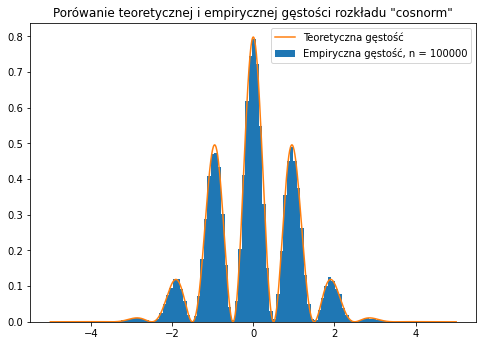

In [16]:
plt.hist(
    EM_sample,
    bins=100,
    density=True
)
plt.plot(space, modified)
plt.title("Porówanie teoretycznej i empirycznej gęstości rozkładu \"cosnorm\"")
plt.legend(["Teoretyczna gęstość", f"Empiryczna gęstość, n = {sample_count}"])
plt.show()

## Zadanie 3
Generacja rozkładu Poissona $ P \sim Pois(\lambda) $


### Metoda 1: Konstrukcja
Niech $(X_n)_{n \in \mathbb{N}}$ taki, że $X_i$ iid, oraz $X_i \sim EXP(\lambda) \ \forall_i$.

Wtedy $N_t = \max \{n: X_1 + ... + X_n \le t\}$ to process Poissona, który ma rozkład $ N_t \sim Pois(\lambda t)$

#### Generowanie z rozkładu $EXP(\lambda)$
Niech $ X \sim EXP(\lambda) $.

Wtedy $ F_X(x) = 1 - e^{-\lambda x}$

$ 1 - F_X(x) = e^{-\lambda x}$

$ \ln(1 - F_X(x)) = -\lambda x$

$ -\frac{\ln(1 - F_X(x))}{\lambda} = x$

Zatem $F_X^{-1}(x) = -\frac{\ln(1 - x)}{\lambda} $

In [17]:
def to_exp(x, l):
    return -np.log(1-x)/l

def exp_rng(l):
    return to_exp(uniform_bulitin_rng(), l)

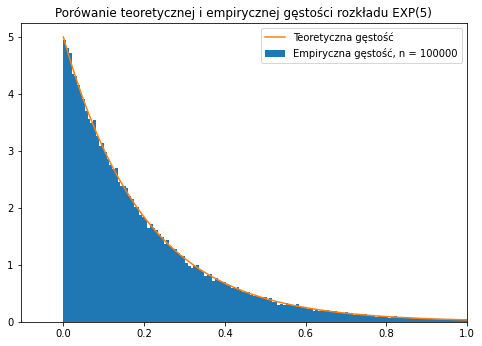

In [18]:
rate = 5
plt.hist(
    [to_exp(uniform_bulitin_rng(), rate) for _ in range(sample_count)],
    bins = int(np.sqrt(sample_count)),
    density = True,
)
plt.plot(
    np.linspace(0, 2, 1000),
    expon.pdf(
        np.linspace(0, 2, 1000),
        scale=1/rate # scale = 1 / rate, my definiujemy po rate
    ) 
)
plt.xlim(right=1)
plt.title(f"Porówanie teoretycznej i empirycznej gęstości rozkładu EXP({rate})")
plt.legend(["Teoretyczna gęstość", f"Empiryczna gęstość, n = {sample_count}"])
plt.show()

#### Konstrukcja
Dla $N_t = \max \{n: X_1 + ... + X_n \le t\}$ i $X_i \sim EXP(\lambda)\ \forall_i$ ustalamy $t = 1$, wtedy $N_1 \sim Pois(\lambda)$.

In [19]:
def poisson_proc(l):
    Nt = 0
    sum_so_far = 0
    while sum_so_far <= 1:
        sum_so_far += exp_rng(l)
        Nt += 1
    # Następny skok przekroczył, czyli jesteśmy o 1 za daleko
    Nt -= 1
    return Nt

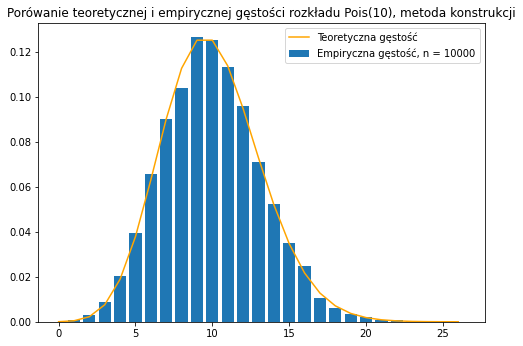

In [20]:
sample_small = 10000
rate = 10

poisson_sample = [poisson_proc(rate) for _ in range(sample_small)]
k_counts = Counter(poisson_sample).keys()
smallest_sample = min(k_counts)
largest_sample = max(k_counts) 

c_counts = Counter(poisson_sample)

plt.bar(
    [i for i in range(smallest_sample, largest_sample + 1)],
    [c_counts[i]/sample_small 
     if i in k_counts 
     else 0 
     for i in range(smallest_sample, largest_sample + 1)]
)

plt.plot(
    np.linspace(0, largest_sample, largest_sample+1),
    poisson.pmf(
        np.linspace(0, largest_sample, largest_sample+1),
        mu=rate 
    ),
    color="orange"
)

plt.title(f"Porówanie teoretycznej i empirycznej gęstości rozkładu Pois({rate}), metoda konstrukcji")
plt.legend(["Teoretyczna gęstość", f"Empiryczna gęstość, n = {sample_small}"])
plt.show()

### Metoda 2: Przedział
Losujemy $U \sim U([0;1])$ i patrzymy w który przedział wpada na dystrybuancie.

In [21]:
@njit
def poisson_rng_levels(l, max_k = 100):
    level = uniform_bulitin_rng()
    current_level = np.exp(-l)
    current_jump = current_level
    k = 1
    while current_level <= level:
        current_jump *= l / k
        current_level += current_jump
        k += 1
    return k - 1

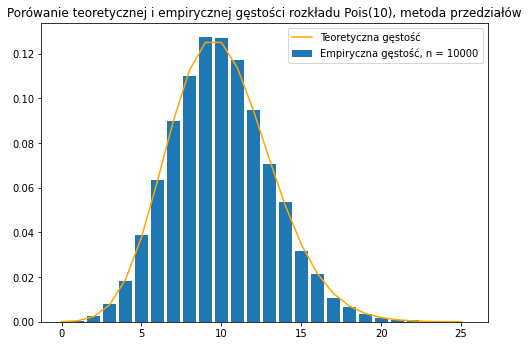

In [22]:
sample_small = 10000
rate = 10

poisson_sample = [poisson_proc(rate) for _ in range(sample_small)]
k_counts = Counter(poisson_sample).keys()
smallest_sample = min(k_counts)
largest_sample = max(k_counts) 

c_counts = Counter(poisson_sample)

plt.bar(
    [i for i in range(smallest_sample, largest_sample + 1)],
    [c_counts[i]/sample_small 
     if i in k_counts 
     else 0 
     for i in range(smallest_sample, largest_sample + 1)]
)

plt.plot(
    np.linspace(0, largest_sample, largest_sample+1),
    poisson.pmf(
        np.linspace(0, largest_sample, largest_sample+1),
        mu=rate 
    ),
    color="orange"
)

plt.title(f"Porówanie teoretycznej i empirycznej gęstości rozkładu Pois({rate}), metoda przedziałów")
plt.legend(["Teoretyczna gęstość", f"Empiryczna gęstość, n = {sample_small}"])
plt.show()

## Zadanie 4
$F(x) =\frac{1}{3}F_{b(10,1/3)}(x) +\frac{1}{3}\Phi(x) +\frac{1}{3}F_{EXP(1)}(x)$

In [23]:
def compound_cdf(x):
    return (
        binom.cdf(x, n=10, p=1/3) +
        norm.cdf(x) +
        expon.cdf(x) 
    ) / 3

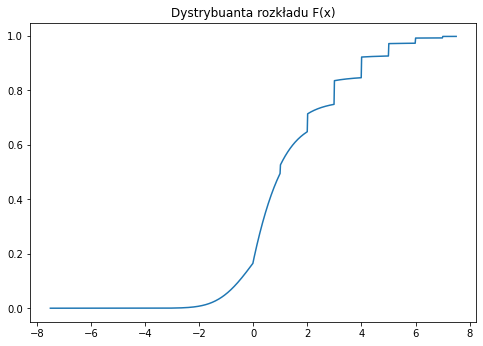

In [24]:
space = np.linspace(-7.5, 7.5, 1001)

plt.plot(
    space,
    compound_cdf(space) 
)

plt.title("Dystrybuanta rozkładu F(x)")
plt.show()

In [25]:
def compound_random():
    # Wybieramy z którego rozkładu losujemy za pomocą pomocniczej y ~ U([0, 1])
    y = uniform_bulitin_rng()
    if y < 1/3:
        return binom.rvs(10, 1/3)
    elif y < 2/3:
        return gauss_builtin_rng(0, 1)
    else:
        return expon.rvs()

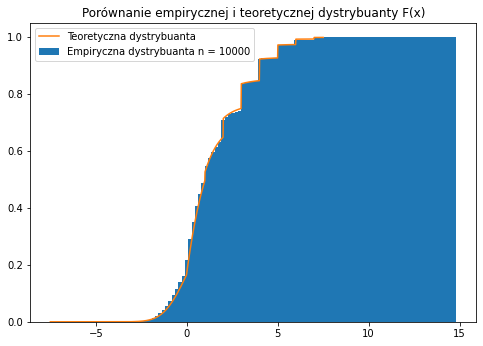

In [26]:
plt.hist(
    [compound_random() for _ in range(sample_small)],
    density=True,
    cumulative=True,
    bins=100
)

space = np.linspace(-7.5, 7.5, 1001)

plt.plot(
    space,
    compound_cdf(space) 
)

plt.title("Porównanie empirycznej i teoretycznej dystrybuanty F(x)")
plt.legend([
    "Teoretyczna dystrybuanta",
    f"Empiryczna dystrybuanta n = {sample_small}"
])
plt.show()

## Zadanie 5
Zaprezentuję i zmierzę czasy kilku podejść:
* Liniowy generator w Pythonie
* Uruchomienie JKISS przez `bash` (brak interakcji z Pythonem)
* Uruchomienie JKISS przez `ctypes` (FFI)
* Liniowy generator w `numba`
* Liniowy generator w `numba` z tablicą `numpy`

In [27]:
%%file kiss.c
#include <stdio.h>
static unsigned int x = 123456789, y = 987654321, z = 43219876,c = 6543217; /* Seed variables */
double JKISS() {
    unsigned long long t;
    x = 314527869 * x + 1234567;
    y ^= y << 5;
    y ^= y >> 7;
    y ^= y << 22;
    t = 4294584393ULL * z + c;
    c = t >> 32;
    z = t;
    double r = ((double) (x + y + z)) / 4294967296.0;
    return r;
}
int main() {
    double r[1000000];
    for (int i = 0; i < 1000000; i++) {
        r[i] = JKISS();
    }
    printf("%f\n", r[0]);
}

Overwriting kiss.c


Generatory KISS mają sens, gdy:
* Jest potrzebny lepszy (pod względem testów lub wydajności) generator od tego wbudowanego.
* Nie mamy biblioteki standardowej, a potrzebujemy pRNG.
* Potrzebujemy prostego generatora, który potrafimy odtworzyć.

### Python

In [28]:
%%time
lingen = linear_generator()
[next(lingen) for _ in range(1000000)]
None

CPU times: user 510 ms, sys: 11.7 ms, total: 522 ms
Wall time: 521 ms


### JKISS (bez FFI)

In [37]:
%%bash
gcc -O2 -o kiss.o kiss.c
time ./kiss.o

0.130441



real	0m0,006s
user	0m0,003s
sys	0m0,003s


### JKISS (FFI)

In [30]:
%%bash 
gcc -O2 -shared -Wl,-soname,kiss -fpic -o kiss.so kiss.c

In [31]:
import ctypes
import os
from importlib import reload
kiss = ctypes.CDLL(os.getcwd() + "/kiss.so")
kiss.JKISS.restype = ctypes.c_double
kiss.JKISS()

0.13044139207340777

In [32]:
%%time
[kiss.JKISS() for _ in range(1000000)]
None

CPU times: user 237 ms, sys: 8.03 ms, total: 245 ms
Wall time: 245 ms


### Numba JIT

In [33]:
@njit
def linear_rng_jit(last_x, m, a_0, a_1):
    last_x = (last_x * a_1 + a_0) % m
    return last_x

@njit
def linear_generator_jit(
        seed=123,
        k = 1,
        a_0 = (exp(1) * 1e9)//1,
        a_1 = (pi * 1e9)//1, 
        m = 2 ** 35
    ):
    last_x = linear_rng_jit(seed, m, a_0, a_1)      
    while True:
        yield last_x/(m-1)
        last_x = linear_rng_jit(last_x, m, a_0, a_1)

lingenjit = linear_generator_jit()
[next(lingenjit) for _ in range(1000)] # rozgrzewka JIT
None

In [34]:
%%time
lingenjit = linear_generator_jit()
[next(lingenjit) for _ in range(1000000)]
None

CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 253 ms


### Numba + NumPy

In [35]:
@njit
def sample_lingenjit_to_numpy(n):
    arr = np.empty(n, dtype="float64")
    lingen = linear_generator_jit()
    for i in range(n):
        arr[i] = next(lingen)
    return arr

sample_lingenjit_to_numpy(100) # rozgrzewka JIT
None

In [36]:
%%time
sample_lingenjit_to_numpy(1000000)
None

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 115 ms


Wniosek jest taki, że nie wystarczy, że przepiszemy kod w C i załadujemy do Pythona, ale też trzeba mądrze go uruchamiać.